In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!pip install tensorflow
!pip install opencv-python
!pip install numpy
!pip install matplotlib

In [14]:
#импортируем разное
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, Conv2DTranspose, Concatenate, LeakyReLU, Dropout

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
dataset = tf.data.TFRecordDataset('/content/drive/MyDrive/bounding_box_dataset.tfrecord')


def parse_record(record):
    #нужно описать приходящий экземпляр
    #имена элементов как при записи
    feature_description = {
        'img': tf.io.FixedLenFeature([], tf.string),
        'cords': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_record = tf.io.parse_single_example(record, feature_description)
    img = tf.io.parse_tensor(parsed_record['img'], out_type=tf.float32)
    cords = tf.io.parse_tensor(parsed_record['cords'], out_type=tf.float32)
    return img, cords

#пройдемся по записи и распакуем ее
dataset = dataset.map(parse_record)
dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(32).shuffle(10)

In [16]:
inputs = Input((256,256,3))
x = Conv2D(32, 3, activation = 'relu', padding = 'same')(inputs)
x = Conv2D(64, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(64, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(256, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Conv2D(256, 3, activation = 'relu', padding = 'same')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(30)(x)  #3*10 = 30 у нейросети это просто выходы подряд

outputs = x

boxregressor = keras.Model(inputs, outputs)

In [17]:
def IoU_Loss(true, pred):
    #(32, 5, 4)
    t1 = true
    t2 = pred

    minx1, miny1, maxx1, maxy1 = tf.split(t1, 4, axis = 2)

    fminx, miny2, fmaxx = tf.split(t2, 3, axis = 2)

    minx2 = tf.minimum(fminx, fmaxx)
    maxx2 = tf.maximum(fminx, fmaxx)

    delta = maxx2 - minx2

    maxy2 = miny2 + delta


    intersection = 0.0

    #найдем пересечение каждого из предсказанных с каждым из реальных
    #сложим все вместе
    for i1 in range(10):
        for i2 in range(10):
            x_overlap = tf.maximum(0.0, tf.minimum(maxx1[:,i1], maxx2[:,i2]) - tf.maximum(minx1[:,i1], minx2[:,i2]))
            y_overlap = tf.maximum(0.0, tf.minimum(maxy1[:,i1], maxy2[:,i2]) - tf.maximum(miny1[:,i1], miny2[:,i2]))
            intersection += x_overlap*y_overlap

    #с несколькими обьектами сложнее. Мы не можем просто найди обьединение трех и более прямоугольников по координатам
    #пойдем на некоторые хитрости.
    #не будем считасть обьединение и сравнивать его с пересечение как в IoU
    #а будем стремится сделать площади всех элементов такими-же, как у реальных рамок
    #просто среднеквадратичной ошибкой

    beta1 = 0.0
    for i1 in range(10):
        for i2 in range(10):
            x_overlap = tf.maximum(0.0, tf.minimum(maxx1[:,i1], maxx1[:,i2]) - tf.maximum(minx1[:,i1], minx1[:,i2]))
            y_overlap = tf.maximum(0.0, tf.minimum(maxy1[:,i1], maxy1[:,i2]) - tf.maximum(miny1[:,i1], miny1[:,i2]))
            if i1 == i2:
                beta1 += (x_overlap*y_overlap)**2
            else:
                beta1 += x_overlap*y_overlap



    beta2 = 0.0
    for i1 in range(10):
        for i2 in range(10):
            x_overlap = tf.maximum(0.0, tf.minimum(maxx2[:,i1], maxx2[:,i2]) - tf.maximum(minx2[:,i1], minx2[:,i2]))
            y_overlap = tf.maximum(0.0, tf.minimum(maxy2[:,i1], maxy2[:,i2]) - tf.maximum(miny2[:,i1], miny2[:,i2]))
            if i1 == i2:
                beta2 += (x_overlap*y_overlap)**2
            else:
                beta2 += x_overlap*y_overlap


    loss = (beta1 - beta2)**2 - intersection

    return loss

In [18]:
class Model(tf.keras.Model):
    def __init__(self, nn_box):
        super(Model, self).__init__()
        self.nn_box = nn_box

        self.box_optimizer = tf.keras.optimizers.Adam(3e-4, clipnorm = 1.0)

    @tf.function
    def training_step(self, x, true_boxes):

        with tf.GradientTape() as tape_box:

            pred = self.nn_box(x, training=True)
            pred = tf.reshape(pred, [-1, 10, 3])

            loss = IoU_Loss(true_boxes, pred)
      #      print('test', tf.reduce_mean(IoU_Loss(true_boxes, true_boxes) ))

        # Backpropagation.
        grads = tape_box.gradient(loss, self.nn_box.trainable_variables)
        self.box_optimizer.apply_gradients(zip(grads, self.nn_box.trainable_variables))

        return loss

model = Model(boxregressor)

In [20]:
for i, c in dataset.take(1):
    print(tf.reduce_mean(model.training_step(i, c)))

tf.Tensor(0.42795032, shape=(), dtype=float32)


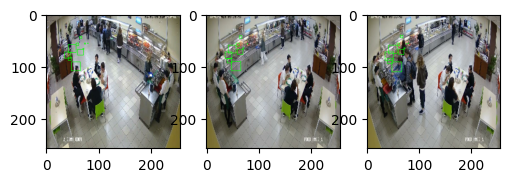

In [24]:

def testing():
    for ii, cc in dataset.take(1):
        #обрабатывем целый батч, используем только пять элементов
        pred = model.nn_box(ii)
        plt.figure(figsize=(10, 6))

        for num in range(3):
            i = ii[num]

            pred = tf.reshape(pred, [-1, 10, 3])
            c = pred[num]

            ax = plt.subplot(1, 5, num+1)
            #переход в numpy для работы в opencv
            i = i.numpy()
            c = c.numpy()
            c = (c+1)/2*128 #обратно из от -1...1 к 0...64
            c = c.astype(np.int16)  #для opencv
            for bb in c:
                bb0 = min(bb[0] ,bb[2])
                bb2 = max(bb[0] ,bb[2])
                i = cv2.rectangle(i ,(bb0 ,bb[1] ),(bb2, bb[1] + (bb2- bb0)),(0,1,0),1)
            plt.imshow(i)

        plt.show()
       # print(c)

testing()

100


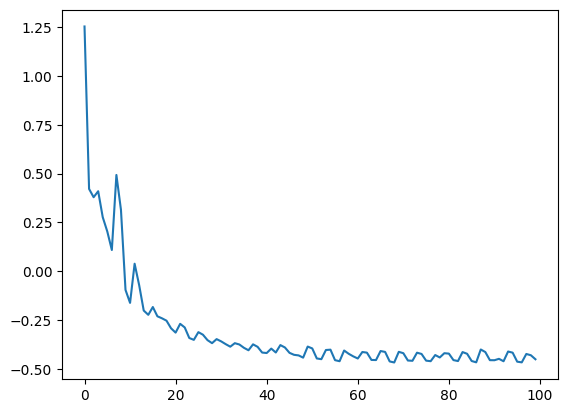

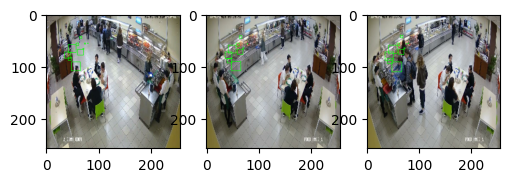

In [22]:
from IPython.display import clear_output
hist = np.array(np.empty([0]))
epochs = 100
ff = 0
for epoch in range(1, epochs + 1):
    loss = 0
    lc = 0
    for step, (i, c) in enumerate(dataset):
        loss+=tf.reduce_mean(model.training_step(i,c))
        lc+=1
    clear_output(wait=True)
    print(epoch)
    hist = np.append(hist, loss/lc)

    plt.plot(np.arange(0,len(hist)), hist)
    plt.show()
    testing()

In [23]:
model.nn_box.save('/content/drive/MyDrive/models_SiriusAI/modelv1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [85]:
dataset_class = tf.data.TFRecordDataset('/content/drive/MyDrive/classifier_datasets.tfrecord')

def parse_record(record):
    feature_description = {
        'img': tf.io.FixedLenFeature([], tf.string),
        'name': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_record = tf.io.parse_single_example(record, feature_description)
    img = tf.io.parse_tensor(parsed_record['img'], out_type=tf.float32)
    name = tf.io.parse_tensor(parsed_record['name'], out_type=tf.int32)
    return img, name


dataset_class = dataset_class.map(parse_record)

for i, c in dataset_class.take(1):
    print(c)

dataset_class = dataset_class.shuffle(50).cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(8).shuffle(50)

tf.Tensor(0, shape=(), dtype=int32)


In [83]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet',
                                               include_top=False,
                                               input_shape=(256,256, 3))
base_model.trainable = False

In [84]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, GlobalAveragePooling2D, Dropout

#давайте напишем нейросеть

inputs = Input((256,256,3))
x = base_model(inputs)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(3, activation = 'softmax')(x)

outputs = x

classifier = keras.Model(inputs, outputs)

In [91]:
class Model(tf.keras.Model):
    def __init__(self, nn):
        super(Model, self).__init__()
        self.nn = nn
        self.optimizer = tf.keras.optimizers.Adam(1e-3)

    def get_loss(self, y, preds):
        loss = tf.keras.losses.CategoricalCrossentropy()(tf.one_hot(y, 3),preds)
        return loss

    @tf.function
    def training_step(self, x , y):
        with tf.GradientTape() as tape:

            preds = self.nn(x)
            loss = self.get_loss(y, preds)

        gradients = tape.gradient(loss, self.nn.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.nn.trainable_variables))
        return tf.reduce_mean(loss)

model_2 = Model(classifier)

In [92]:
for i, c in dataset_class.take(1):
    print(tf.reduce_mean(model_2.training_step(i, c)))

tf.Tensor(2.0887284, shape=(), dtype=float32)


10


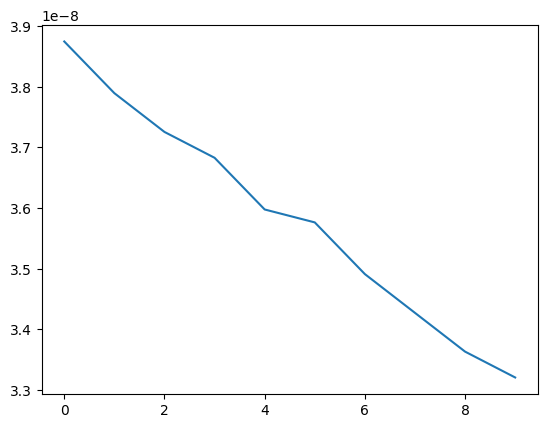

In [95]:
from IPython.display import clear_output
hist = np.array(np.empty([0]))
epochs = 10

for epoch in range(1, epochs + 1):
    loss = 0
    lc = 0
    for step, (i, n) in enumerate(dataset_class):
        loss+=tf.reduce_mean(model_2.training_step(i,n))
        lc+=1
    clear_output(wait=True)
    print(epoch)
    hist = np.append(hist, loss/lc)
    plt.plot(np.arange(0,len(hist)), hist)
    plt.show()

[0.0000000e+00 1.0000000e+00 1.2779156e-25]
[1.4040334e-35 1.0000000e+00 2.0928125e-25]
[0. 1. 0.]
[2.6087607e-27 1.0000000e+00 4.2100382e-33]
[0.000000e+00 1.000000e+00 7.429887e-33]


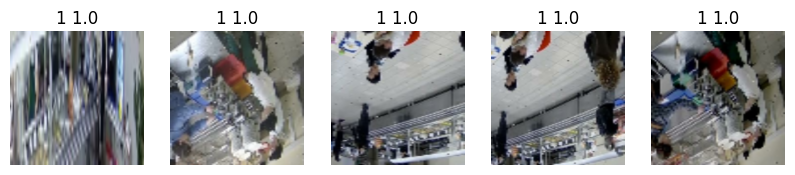

In [97]:
def imshow_and_pred():
    n = 5
    plt.figure(figsize=(10, 6))
    for images, labels in dataset_class.take(1):
        preds = model_2.nn(images)
        for i in range(n):
            img = images[i]


            pred = preds[i].numpy()
            print(pred)
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(img, cmap='gist_gray')

            ma = pred.max()
            res = np.where(pred == ma)

            plt.title(str(res[0][0]) +' '+ str(round(pred[res[0][0]], 3)))
            plt.axis('off')
            ax.get_yaxis().set_visible(False)
    plt.show()
imshow_and_pred()

In [98]:
model.nn.save('/content/drive/MyDrive/models_SiriusAI/my_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [99]:
localizator = tf.keras.models.load_model('/content/drive/MyDrive/models_SiriusAI/modelv1.h5')
classifier = tf.keras.models.load_model('/content/drive/MyDrive/models_SiriusAI/my_classifier.h5')

In [109]:
def Detect_objects(image):
    image = tf.cast(image, dtype = tf.float32) / 256
    small_image = tf.image.resize(image, (256, 256))
    big_image = tf.image.resize(image, (256, 256))
    image_exp = tf.expand_dims(small_image, axis = 0)

    bb_cords = localizator(image_exp)
    bb_cords = tf.squeeze(bb_cords, axis = 0)

    bb_cords = (bb_cords+1)/2*256
    bb_cords = tf.reshape(bb_cords, [10, 3])

    fxmin, ymin, fxmax = tf.split(bb_cords, 3, axis = 1)

    xmin = tf.minimum(fxmin, fxmax)
    xmax = tf.maximum(fxmin, fxmax)

    xmin = tf.clip_by_value(xmin, 0, 256)
    ymin = tf.clip_by_value(ymin, 0, 256)

    size = xmax - xmin

    xsize = tf.clip_by_value(size, 1, 256 - xmin)
    ysize = tf.clip_by_value(size, 1, 256 - ymin)

    ymin*= 8
    xmin*= 8
    ysize*= 8
    xsize*= 8
    for n in range(10):
        ii = tf.image.crop_to_bounding_box(big_image, int(ymin[n][0]), int(xmin[n][0]), int(ysize[n][0]), int(xsize[n][0]))
        ii = tf.image.resize(ii, (256,256))
        ii = tf.expand_dims(ii, axis = 0)
        if n == 0:
            cropped = ii
        else:
            cropped = tf.concat([cropped, ii], axis = 0)

    probs = classifier(cropped)

    probs = probs.numpy()

    ma = np.amax(probs, axis = 1)
    ma = np.expand_dims(ma, axis = 1)
    _, classes = np.where(probs == ma)

    res_probs = []
    for a in range(10):
        res_probs.append(probs[a][classes[a]])

    #собираем координаты в нормальный вид
    cords = tf.concat([xmin/8, ymin/8, xmin/8+xsize/8, ymin/8+ysize/8], axis = 1)
    cords = cords.numpy()


    return cords, classes, res_probs

In [102]:
namespace = {0: 'people', 1: 'head' , 2: 'leg'}

def visualize(in_image, cords, classes, probs, th = 0.8):
    big_image = tf.image.resize(in_image, (256,256)).numpy() / 256

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    thickness = 2

    for i in range(len(cords)):
        if classes[i]!= 0 and probs[i] >= th:
            if classes[i] == 1:
                color = (1, 0, 0)
            if classes[i] == 2:
                color = (0, 1, 0)
            text = namespace[classes[i]] + ' ' + str(probs[i]*100) + '%'

            org = ((int(cords[i][0])*8,  int(cords[i][1])*8-10))
            big_image = cv2.putText(big_image, text, org, font, fontScale, color, thickness, cv2.LINE_AA)
            big_image = cv2.rectangle(big_image ,(int(cords[i][0])*8, int(cords[i][1])*8),(int(cords[i][2])*8,int(cords[i][3])*8),color,5)



    return big_image

In [104]:
def prettify(cords, classes, probs, tau = 0.5):
    newcords = []
    newclasses = []
    newprobs = []

    for i1 in range(len(classes)):

        if classes[i1]!=0:
            found = False
            for i2 in range(len(classes)):
                if classes[i2]!=0 and  i1 != i2:

                    x_overlap = max(0, min(cords[i1][2], cords[i2][2]) - max(cords[i1][0], cords[i2][0]))
                    y_overlap = max(0, min(cords[i1][3], cords[i2][3]) - max(cords[i1][1], cords[i2][1]))
                    inter = x_overlap*y_overlap
                    area1 = (cords[i1][2] - cords[i1][0])*(cords[i1][3] - cords[i1][1])
                    area2 = (cords[i2][2] - cords[i2][0])*(cords[i2][3] - cords[i2][1])
                    union = area1+area2 - inter
                    IoU = inter/union
                    if IoU > tau:

                        newcord = [(cords[i1][0]+ cords[i2][0])//2,(cords[i1][1]+ cords[i2][1])//2,(cords[i1][2]+ cords[i2][2])//2,(cords[i1][3]+ cords[i2][3])//2]
                        newcords.append(newcord)

                        newclasses.append(classes[i1])
                        newprobs.append(probs[i1])

                        classes[i1] = 0
                        classes[i2] = 0
                        found = True

            if found == False:
                newcords.append(cords[i1])
                newclasses.append(classes[i1])
                newprobs.append(probs[i1])



    return newcords, newclasses, newprobs

In [ ]:
def load_img(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (256, 256))
    return img


image = load_img('/content/drive/MyDrive/Снимок экрана 2024-05-15 в 00.15.45.png')
print(image)
cords, classes, probs = Detect_objects(image)
for i in range(1):
    cords, classes, probs = prettify(cords, classes, probs, 0.1)
result = visualize(image, cords, classes, probs, 0.5)
plt.figure(figsize=(10, 6))
ax = plt.subplot(1,1,1)
plt.imshow(result)
plt.show()